# qSIM Summary

In [1]:
%run '../ipython_startup.py'

Importing commonly used libraries: os, sys, numpy as np, scipy as sp, pandas as pd, matplotlib as mp, matplotlib.pyplot as plt, datetime as dt, mclib_Python/flagging as fg
Creating project level variables: MCLAB = /home/jfear/mclab, PROJ = /home/jfear/mclab/cegs_ase_paper, TODAY = 20150831
Adding ['scripts/mclib_Python', 'scripts/ase_Python'] to PYTHONPATH


In [2]:
import cPickle as pickle
import sas7bdat

In [3]:
# Import qSIM
fname = '../../sas_data/ase_qsim_tester.sas7bdat'
with sas7bdat.SAS7BDAT(fname) as FH:
    df = FH.to_data_frame()

# Create flag
## 0: qsim == 0.5
df['flag_qsim'] = int(0)

## -1: qsim < 0.5
df.loc[(df['qsim_tester'] < 0.5), 'flag_qsim'] = int(-1)

## 1: qsim > 0.5
df.loc[(df['qsim_tester'] > 0.5), 'flag_qsim'] = int(1)

# Pivot to wide
dfT = df.pivot_table(values='flag_qsim', columns='line', index='fusion_id')
dfT.head()

[ase_qsim_tester.sas7bdat] header length 65536 != 8192


line,r101,r109,r136,r149,r181,r208,r21,r217,r228,r280,...,w47,w52,w55,w59,w64,w67,w68,w74,w76,w79
fusion_id,,,,,,,,,,,,,,,,,,,,,
F10001_SI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F10005_SI,0,0,0,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
F10009_SI,-1,-1,-1,-1,-1,0,-1,0,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
F10012_SI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F10014_SI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Drop ambiguous fusion_ids

Drop fusion_ids that were always ambiguous in the 100 genome simulation.

In [4]:
# Import drop list from 100 genome simulation
toDrop = pickle.load(open(os.path.join(PROJ, 'pipeline_output/100_genome_simulation/exonic_region_drop_list.pkl'), 'rb'))

# Drop exonic regions that are always bias in 100 genome sim
dfTFilter = dfT.drop(toDrop)

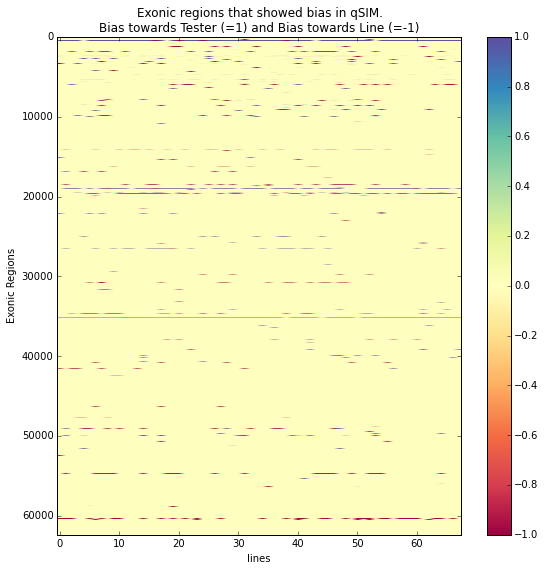

In [5]:
# Plot heatmap
fig = plt.figure(figsize=(8, 8))
plt.imshow(dfTFilter, aspect='auto', cmap=plt.cm.Spectral)
plt.xlabel('lines')
plt.ylabel('Exonic Regions')
plt.title(u'Exonic regions that showed bias in qSIM.\nBias towards Tester (=1) and Bias towards Line (=-1)')
plt.colorbar()
plt.tight_layout()
plt.savefig('../../pipeline_output/qsim_bayesian/heatmap_genome_ambiguity_fb551_qsim.png')

In [6]:
# Summarize exonic region bias across lines
numLineBias = dfTFilter.apply(lambda x: sum(abs(x)), axis=1)
numLine = dfTFilter.count(axis=1)

# Create flags DataFrame
flags = fg.FlagsDataFrame(index=dfTFilter.index)

# Flag exonic regions with no bias
flags.addColumn('flag_exons_no_bias_qsim', (numLineBias == 0))

# Flag exonic regions with any bias
flags.addColumn('flag_exons_w_bias_qsim', (numLineBias > 0))

# Flag exonic regions with bias in 50% lines
flags.addColumn('flag_exons_bias_in_half_qsim', (numLineBias >= 50))

# Flag exonic regions with bias in all 100 lines
flags.addColumn('flag_exons_bias_in_all_qsim', (numLineBias == 100))

# Output counts
print(flags.sum())

# Output total number of exonic regions
print('Number of exonic regions: {}'.format(flags.shape[0]))

flag_exons_no_bias_qsim         53923
flag_exons_w_bias_qsim           8451
flag_exons_bias_in_half_qsim      252
flag_exons_bias_in_all_qsim         0
dtype: int64
Number of exonic regions: 62374


In [7]:
# Export to excel table to publication
flagsI = flags.reset_index()
flagsI.to_excel('../../pipeline_output/qsim_bayesian/flag_exonic_region_w_and_wo_bias_qsim.xls', index=None)

In [8]:
# Number of exonic regions biased towards tester in at least 1 genotype
((dfTFilter == 1).sum(axis=1) > 0).sum()

4634

In [9]:
# Number of exonic regions biased towards line in at least 1 genotype
((dfTFilter == -1).sum(axis=1) > 0).sum()

5709